# Passive membrane parameters

Reported in table 1.

In [1]:
from common import colors, savefig

In [2]:
import os
os.chdir(os.path.join('..', '..'))
print(os.getcwd())

/home/efharkin/projects/raphegif/raphegif


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.lines import Line2D
import seaborn as sns
from ezephys import pltools

In [4]:
IMG_PATH = os.getenv('IMG_PATH')
plt.style.use(os.path.join('figs', 'scripts', 'publication_figure_style.dms'))

In [5]:
def get_membrane_params_from_all_csv_files(dir_to_search):
    tables = [
        pd.read_csv(os.path.join(dirpath, filename), comment='#')
        for (dirpath, dirs, files) in os.walk(dir_to_search)
        for filename in (dirs + files)
        if filename.lower().endswith('.csv') and 'heated' not in dirpath.lower()
    ]
    required_columns = ['cell_id', 'membrane_resistance_megaohm', 'membrane_capacitance_picofarad']
    master_table = pd.concat(
        [
            t.loc[:, required_columns] 
            for t in tables 
            if set(t.columns) >= set(required_columns)
        ],
        ignore_index=True
    )
    return master_table

In [6]:
ser_master_table = get_membrane_params_from_all_csv_files(os.path.join(os.getenv('DATA_PATH'), 'raw', '5HT'))
ser_master_table = ser_master_table.groupby('cell_id').mean()  # Remove duplicate cells.
ser_master_table['cell_type'] = 'ser'

In [7]:
som_master_table = get_membrane_params_from_all_csv_files(os.path.join(os.getenv('DATA_PATH'), 'raw', 'GABA'))
som_master_table = som_master_table.groupby('cell_id').mean()  # Remove duplicate cells.
som_master_table['cell_type'] = 'som'

In [8]:
pyr_master_table = get_membrane_params_from_all_csv_files(os.path.join(os.getenv('DATA_PATH'), 'raw', 'mPFC'))
pyr_master_table = pyr_master_table.groupby('cell_id').mean()  # Remove duplicate cells.
pyr_master_table['cell_type'] = 'pyr'

In [9]:
membrane_params = pd.concat([ser_master_table, som_master_table, pyr_master_table])
membrane_params['tau'] = (
    1e-3
    * membrane_params['membrane_resistance_megaohm'] 
    * membrane_params['membrane_capacitance_picofarad']
)
membrane_params['leak_conductance_nanosiemen'] = (
    1e3 / membrane_params['membrane_resistance_megaohm']
)
membrane_params.groupby('cell_type').mean()

,membrane_resistance_megaohm,membrane_capacitance_picofarad,tau,leak_conductance_nanosiemen
cell_type,,,,
pyr,187.706667,160.580000,27.447497,6.892384
ser,1155.559028,66.992083,75.219403,1.017984
som,1067.392857,43.526786,42.249536,1.260469


In [10]:
membrane_params.groupby('cell_type').sem()

,membrane_resistance_megaohm,membrane_capacitance_picofarad,tau,leak_conductance_nanosiemen
cell_type,,,,
pyr,25.963058,9.646133,2.646865,0.550430
ser,56.455921,1.749589,3.451856,0.040728
som,110.219590,2.931604,3.738623,0.145187


In [11]:
membrane_params.groupby('cell_type').std()

,membrane_resistance_megaohm,membrane_capacitance_picofarad,tau,leak_conductance_nanosiemen
cell_type,,,,
pyr,129.815292,48.230665,13.234324,2.752150
ser,553.152802,17.142404,33.821141,0.399054
som,583.227250,15.512590,19.782934,0.768255


In [12]:
membrane_params.groupby('cell_type').median()

,membrane_resistance_megaohm,membrane_capacitance_picofarad,tau,leak_conductance_nanosiemen
cell_type,,,,
pyr,135.0,166.0,26.450,7.407407
ser,1000.0,66.5,70.433,1.000000
som,1000.0,38.0,40.400,1.000000


In [13]:
membrane_params.groupby('cell_type').count()

,membrane_resistance_megaohm,membrane_capacitance_picofarad,tau,leak_conductance_nanosiemen
cell_type,,,,
pyr,25,25,25,25
ser,96,96,96,96
som,28,28,28,28


## Membrane parameter statistics

### Resistance

In [14]:
result = stats.mannwhitneyu(
    membrane_params.groupby('cell_type').get_group('pyr')['membrane_resistance_megaohm'],
    membrane_params.groupby('cell_type').get_group('som')['membrane_resistance_megaohm'],
    alternative='two-sided'
)
print(result.pvalue * 3)

5.935848760699349e-09


In [15]:
result = stats.mannwhitneyu(
    membrane_params.groupby('cell_type').get_group('pyr')['membrane_resistance_megaohm'],
    membrane_params.groupby('cell_type').get_group('ser')['membrane_resistance_megaohm'],
    alternative='two-sided'
)
print(result.pvalue * 3)

6.523348077346987e-14


In [16]:
result = stats.mannwhitneyu(
    membrane_params.groupby('cell_type').get_group('ser')['membrane_resistance_megaohm'],
    membrane_params.groupby('cell_type').get_group('som')['membrane_resistance_megaohm'],
    alternative='two-sided'
)
print(result.pvalue * 3)

1.0247001545202665


### Time constant

In [17]:
result = stats.mannwhitneyu(
    membrane_params.groupby('cell_type').get_group('pyr')['tau'],
    membrane_params.groupby('cell_type').get_group('som')['tau'],
    alternative='two-sided'
)
print(result.pvalue * 3)

0.015036861436466042


In [18]:
result = stats.mannwhitneyu(
    membrane_params.groupby('cell_type').get_group('pyr')['tau'],
    membrane_params.groupby('cell_type').get_group('ser')['tau'],
    alternative='two-sided'
)
print(result.pvalue * 3)

3.094688446416096e-11


In [19]:
result = stats.mannwhitneyu(
    membrane_params.groupby('cell_type').get_group('ser')['tau'],
    membrane_params.groupby('cell_type').get_group('som')['tau'],
    alternative='two-sided'
)
print(result.pvalue * 3)

1.411559682258308e-06


In [20]:
def counts_to_step(counts, edges):
    """Convert counts and edges from numpy histogram to x and y data for a step histogram plot."""
    counts = np.array([np.concatenate([[0], counts]), np.concatenate([counts, [0]])])
    edges = np.array([edges, edges])
    
    return counts.T.flatten(), edges.T.flatten()

In [21]:
def max_normalized_histogram(x, bins=10, ax=None, vertical=False, **pltargs):
    if ax is None:
        ax = plt.gca()
    
    counts, edges = np.histogram(x, bins)
    y, x = counts_to_step(counts, edges)
    
    if not vertical:
        ax.plot(x, y.astype(np.float64) / y.max(), **pltargs)
    else:
        ax.plot(y.astype(np.float64) / y.max(), x, **pltargs)

/home/efharkin/.miniconda3/envs/raphegif/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Saving svg
Saving png
Done!


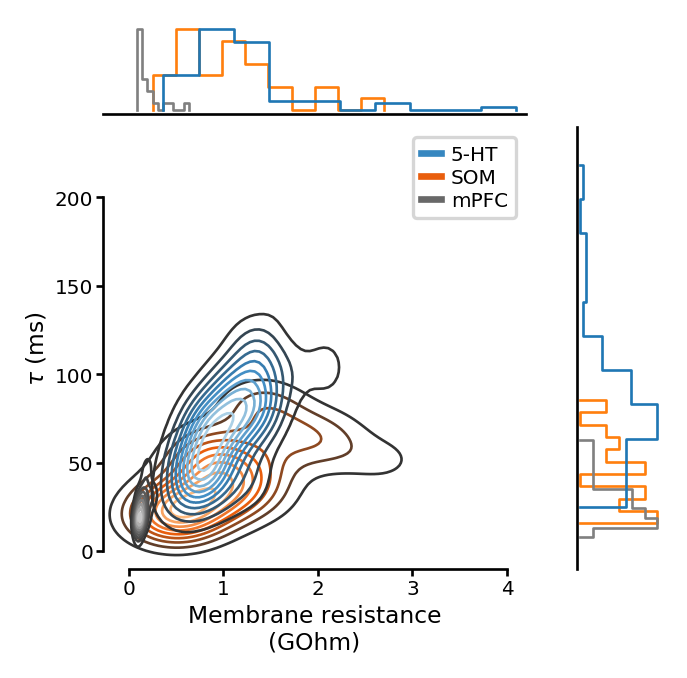

In [22]:
spec = gs.GridSpec(2, 2, height_ratios=[0.2, 1], width_ratios=[1, 0.2], hspace=0.05)

plt.figure(figsize=(3, 3))

plt.subplot(spec[1, 0])
sns.kdeplot(
    membrane_params[membrane_params['cell_type'] == 'som']['membrane_resistance_megaohm'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'som']['tau'],
    shade_lowest=False,
    cmap='Oranges_d',
    label='GABA'
)
sns.kdeplot(
    membrane_params[membrane_params['cell_type'] == 'pyr']['membrane_resistance_megaohm'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'pyr']['tau'],
    shade_lowest=False,
    cmap='Greys_d',
    label='mPFC'
)
sns.kdeplot(
    membrane_params[membrane_params['cell_type'] == 'ser']['membrane_resistance_megaohm'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'ser']['tau'],
    shade_lowest=False,
    cmap='Blues_d',
    label='5HT'
)

custom_lines = [Line2D([0], [0], color=sns.color_palette('Blues_d', 1)[0], lw=2),
                Line2D([0], [0], color=sns.color_palette('Oranges_d', 1)[0], lw=2),
                Line2D([0], [0], color=sns.color_palette('Greys_d', 1)[0], lw=2)]

plt.xlim(-0.270, 4.200)
plt.ylim(-10, 240)
plt.ylabel(r'$\tau$ (ms)')
plt.xlabel('Membrane resistance\n(GOhm)')
plt.legend(custom_lines, ['5-HT', 'SOM', 'mPFC'])
pltools.hide_border('tr', trim=True)

plt.subplot(spec[0, 0])
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'som']['membrane_resistance_megaohm'] * 1e-3, color=colors['som'], clip_on=False)
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'pyr']['membrane_resistance_megaohm'] * 1e-3, color=colors['pyr'], clip_on=False)
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'ser']['membrane_resistance_megaohm'] * 1e-3, color=colors['ser'], clip_on=False)
plt.xlim(-0.270, 4.200)
plt.xticks([])
plt.yticks([])
pltools.hide_border('lrt')

plt.subplot(spec[1, 1])
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'som']['tau'], color=colors['som'], vertical=True, clip_on=False)
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'pyr']['tau'], color=colors['pyr'], vertical=True, clip_on=False)
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'ser']['tau'], color=colors['ser'], vertical=True, clip_on=False)
plt.ylim(-10, 240)
plt.xticks([])
plt.yticks([])
pltools.hide_border('trb')

plt.tight_layout()

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'kde_membrane_params_untruncated'))

Saving svg
Saving png
Done!


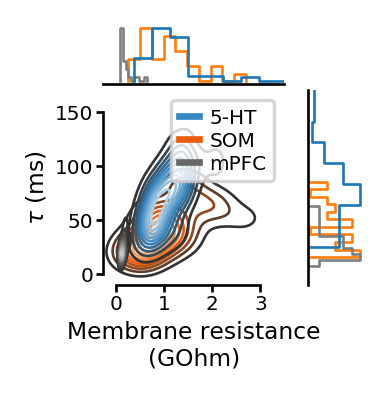

In [23]:
spec = gs.GridSpec(2, 2, height_ratios=[0.3, 1], width_ratios=[1, 0.3], hspace=0.05)

plt.figure(figsize=(1.5, 1.5))

plt.subplot(spec[1, 0])
sns.kdeplot(
    membrane_params[membrane_params['cell_type'] == 'som']['membrane_resistance_megaohm'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'som']['tau'],
    shade_lowest=False,
    cmap='Oranges_d',
    label='GABA'
)
sns.kdeplot(
    membrane_params[membrane_params['cell_type'] == 'pyr']['membrane_resistance_megaohm'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'pyr']['tau'],
    shade_lowest=False,
    cmap='Greys_d',
    label='mPFC'
)
sns.kdeplot(
    membrane_params[membrane_params['cell_type'] == 'ser']['membrane_resistance_megaohm'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'ser']['tau'],
    shade_lowest=False,
    cmap='Blues_d',
    label='5HT'
)

custom_lines = [Line2D([0], [0], color=sns.color_palette('Blues_d', 1)[0], lw=2),
                Line2D([0], [0], color=sns.color_palette('Oranges_d', 1)[0], lw=2),
                Line2D([0], [0], color=sns.color_palette('Greys_d', 1)[0], lw=2)]

plt.xlim(-0.270, 3.500)
plt.xticks([0, 1, 2, 3])
plt.ylim(-10, 170)
plt.ylabel(r'$\tau$ (ms)')
plt.xlabel('Membrane resistance\n(GOhm)')
plt.legend(custom_lines, ['5-HT', 'SOM', 'mPFC'])
pltools.hide_border('tr', trim=True)

plt.subplot(spec[0, 0])
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'som']['membrane_resistance_megaohm'] * 1e-3, color=colors['som'])
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'pyr']['membrane_resistance_megaohm'] * 1e-3, color=colors['pyr'])
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'ser']['membrane_resistance_megaohm'] * 1e-3, color=colors['ser'])
plt.xlim(-0.270, 3.500)
plt.xticks([])
plt.yticks([])
pltools.hide_border('lrt')

plt.subplot(spec[1, 1])
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'som']['tau'], color=colors['som'], vertical=True)
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'pyr']['tau'], color=colors['pyr'], vertical=True)
max_normalized_histogram(membrane_params[membrane_params['cell_type'] == 'ser']['tau'], color=colors['ser'], vertical=True)
plt.ylim(-10, 170)
plt.xticks([])
plt.yticks([])
pltools.hide_border('trb')

plt.subplots_adjust(top=0.97, right=0.97, bottom=0.25, left=0.25)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'kde_membrane_params'))

In [24]:
membrane_params.loc[
    (membrane_params['cell_type'] == 'ser')
    & (
        (membrane_params['membrane_resistance_megaohm'] * 1e-3 > 3.5)
        | (membrane_params['tau'] > 170)
    )
]

,membrane_resistance_megaohm,membrane_capacitance_picofarad,cell_type,tau,leak_conductance_nanosiemen
cell_id,,,,,
DRN268,4100.0,33.0,ser,135.3,0.243902
DRN305,2700.0,65.0,ser,175.5,0.370370
DRN435,2800.0,78.0,ser,218.4,0.357143


Saving svg
Saving png
Done!


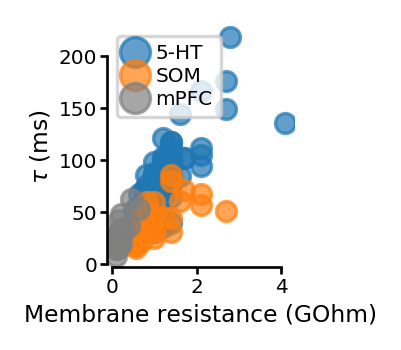

In [25]:
plt.figure(figsize=(1.5, 1.5))

plt.plot(
    membrane_params[membrane_params['cell_type'] == 'ser']['membrane_resistance_megaohm'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'ser']['tau'],
    'o',
    alpha=0.7,
    color=colors['ser'],
    label='5-HT'
)
plt.plot(
    membrane_params[membrane_params['cell_type'] == 'som']['membrane_resistance_megaohm'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'som']['tau'],
    'o',
    alpha=0.7,
    color=colors['som'],
    label='SOM'
)
plt.plot(
    membrane_params[membrane_params['cell_type'] == 'pyr']['membrane_resistance_megaohm'] * 1e-3, 
    membrane_params[membrane_params['cell_type'] == 'pyr']['tau'],
    'o',
    alpha=0.7,
    color=colors['pyr'],
    label='mPFC'
)

plt.ylabel(r'$\tau$ (ms)')
plt.xlabel('Membrane resistance (GOhm)')
plt.legend()
pltools.hide_border('tr', trim=True)

plt.tight_layout()

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'raw_data_membrane_params'))

In [26]:
membrane_params

,membrane_resistance_megaohm,membrane_capacitance_picofarad,cell_type,tau,leak_conductance_nanosiemen
cell_id,,,,,
DRN159,707.000000,43.000000,ser,30.401000,1.414427
DRN160,365.000000,79.000000,ser,28.835000,2.739726
DRN162,485.000000,57.000000,ser,27.645000,2.061856
DRN163,1400.000000,61.000000,ser,85.400000,0.714286
DRN164,919.000000,39.000000,ser,35.841000,1.088139
DRN165,759.000000,63.000000,ser,47.817000,1.317523
DRN196,923.000000,74.000000,ser,68.302000,1.083424
DRN227,1200.000000,86.000000,ser,103.200000,0.833333
DRN229,695.000000,50.000000,ser,34.750000,1.438849
